In [2]:
import os
import sys
os.environ["BACKEND"] = "numpy"
# Set JAX backend if necessary (often not needed explicitly)
# os.environ["JAX_PLATFORM_NAME"] = "cpu" # or "gpu", "tpu"

script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
for i in range(1, 5): # Check up to 4 levels up
    dir_up = os.path.abspath(os.path.join(script_dir, *(['..'] * i)))
    if dir_up not in sys.path:
        sys.path.append(dir_up)
    sys.path.append(os.path.join(dir_up, "QES", "general_python"))

# try to import the gymnasium package, this is used to create a custom environment for quantum vector optimization
import gymnasium as gym
import jax
import jax.numpy as jnp
from jax import tree as jax_tree

import numpy as np
import itertools
from functools import partial

import distrax
import optax
import flax.linen as nn
from typing import Callable, Tuple, List, Optional, Union, Dict, Any, Sequence, NamedTuple
from flax.core import FrozenDict
from flax.training.train_state import TrainState

# common utilities for logging
try:
    from QES.general_python.algebra.utils import JAX_AVAILABLE
    from QES.general_python.algebra.linalg import _apply_givens_rotation_jax
    from QES.general_python.common.flog import Logger, get_global_logger
    from QES.general_python.common.directories import Directories
    from QES.general_python.common.plot import Plotter
    from QES.Algebra.hamil_quadratic import QuadraticSelection
    from QES.general_python.physics.entropy import vn_entropy
    from QES.general_python.physics.entropy_jax import vn_entropy_jax
    from QES.general_python.physics.density_matrix import rho_numba, rho_numba_mask, schmidt_numba
    from QES.general_python.physics.density_matrix_jax import rho_jax, schmidt_jax
except ImportError as e:
    print(f"Error importing custom modules (QES, extractors): {e}")
    print("Please ensure these modules are in the Python path and are JAX-compatible.")
    sys.exit(1)

#! Global Configuration & Initialization

# For reproducibility
master_seed     = np.random.randint(0, 2**32 - 1) 
# master_seed = 42 # Or set a fixed seed
key             = jax.random.PRNGKey(master_seed)
np.random.seed(master_seed)

# Logger setup
logger          = get_global_logger()

07_06_2025_22-17_02 [INFO] Log file created: ./log/QES_07_06_2025_22-17_02.log
07_06_2025_22-17_02 [INFO] Log level set to: info
07_06_2025_22-17_02 [INFO] ############Global logger initialized.############
07_06_2025_22-17_02 [INFO] JAX is not available. Using NumPy as the active backend.
07_06_2025_22-17_02 [INFO] **************************************************
07_06_2025_22-17_02 [INFO] Backend Configuration:
07_06_2025_22-17_02 [INFO] 		NumPy Version: 2.1.3
07_06_2025_22-17_02 [INFO] 		SciPy Version: 1.15.2
07_06_2025_22-17_02 [INFO] 		JAX Version: Not Available
07_06_2025_22-17_02 [INFO] 		Active Backend: numpy
07_06_2025_22-17_02 [INFO] 			JAX Available: False
07_06_2025_22-17_02 [INFO] 			Default Seed: 42
07_06_2025_22-17_02 [INFO] 		NumPy Backend Details:
07_06_2025_22-17_02 [INFO] 				Main Module: numpy
07_06_2025_22-17_02 [INFO] 				Random Module: Generator
07_06_2025_22-17_02 [INFO] 				SciPy Module: scipy
07_06_2025_22-17_02 [INFO] 		Active Data Types:
07_06_2025_22-17_0

In [3]:
def get_random_matching_files(files_org_list, gamma_val, ns_val):
    '''
    Get a random pair of matching ORG and MIX files based on the specified gamma and ns values.
    Args:
        files_org_list (List[str]):
            List of ORG file paths.
        gamma_val (int):
            The gamma value to filter files.
        ns_val (int):
            The ns value to filter files.
    Returns:
        Tuple[str, str]:
            A tuple containing the selected ORG file path and the corresponding MIX file path.
    Raises:
        ValueError: If no matching ORG files are found.
    '''
    # Filter org files
    org_candidates = [str(f) for f in files_org_list if f'gamma={gamma_val}' in str(f) and f'ns={ns_val}' in str(f)]
    if not org_candidates:
        raise ValueError(f"No ORG files found with gamma={gamma_val} and ns={ns_val}.")
    
    # Randomly select one of the matching org files
    selected_org_file = str(np.random.choice(org_candidates))

    # Try to find a corresponding mix file. This logic assumes a naming convention. The mix file should have the same name as the org file.
    selected_mix_file = selected_org_file.replace('org', 'mix')
    logger.info(f"Selected ORG file: {selected_org_file} (from {len(org_candidates)} matches)")
    logger.info(f"Selected MIX file: {selected_mix_file} (should match ORG file naming convention)")
    return selected_org_file, selected_mix_file

In [4]:
def initialize_set_of_states(gamma_select, ns, dim_a, dim_b, org_nh):
    base_data_dir   = os.path.join(script_dir, 'data')
    directory_org   = Directories(os.path.join(base_data_dir, 'org'))
    directory_mix   = Directories(os.path.join(base_data_dir, 'mix'))

    # List all files in the directories
    files_org       = directory_org.list_files(filters=[lambda x: str(x).endswith('.npy')])
    files_mix       = directory_mix.list_files(filters=[lambda x: str(x).endswith('.npy')])

    # Check if we have any files to process
    try:
        random_file_org_path, random_file_mix_path = get_random_matching_files(files_org, gamma_select, ns)
        
        logger.info(f"Loading original data from: {random_file_org_path}", lvl = 1, color = 'green')
        data_org        = np.load(random_file_org_path)
        data_org_jax    = jnp.array(data_org)
        logger.info(f"Loading mixed data from: {random_file_mix_path}", lvl = 1, color = 'blue')
        data_mix        = np.load(random_file_mix_path)
        data_mix_jax    = jnp.array(data_mix)
    except (FileNotFoundError, ValueError) as e:
        logger.error(f"Error during data loading/selection: {e}")
        sys.exit(1)

    logger.info(f"Loaded data_org_jax with shape: {data_org_jax.shape}", lvl = 1, color = 'green')
    logger.info(f"Loaded data_mix_jax with shape: {data_mix_jax.shape}", lvl = 1, color = 'green')
    logger.info("Calculating initial entanglement for a few original states (from data_org_jax):", lvl = 1, color = 'red')

    # Calculate entanglement for the original states
    num_states_to_check = min(data_org_jax.shape[1], 5)
    gamma               = data_org_jax.shape[1]
    entropy_values      = {
        'original'      : [],
        'mixed'         : [],
        'minimum'       : float('inf'),
        'maximum'       : float('-inf'),
        'minimum_mixed' : float('inf'),
        'maximum_mixed' : float('-inf'),
        'average'       : 0.0,
        'average_mixed' : 0.0
    }

    # Process original states
    for i in range(gamma):
        state                               = data_org_jax[:, i]
        state_norm                          = jnp.linalg.norm(state)
        schmidt_values, _                   = schmidt_jax(state, dim_a, dim_b, use_eig=False)
        entropy                             = vn_entropy_jax(schmidt_values)
        entropy_values['original'].append(entropy)
        entropy_values['minimum']           = min(entropy_values['minimum'], entropy)
        entropy_values['maximum']           = max(entropy_values['maximum'], entropy)
        entropy_values['average']          += entropy / gamma
        if i < num_states_to_check:
            logger.info(f"Original state {i}: Entropy = {entropy:.5f}", color='blue', lvl=2)

    # Process mixed states
    for i in range(gamma):
        state                               = data_mix_jax[:, i]
        state_norm                          = jnp.linalg.norm(state)
        schmidt_values, _                   = schmidt_jax(state, dim_a, dim_b, use_eig=False)
        entropy                             = vn_entropy_jax(schmidt_values)
        entropy_values['mixed'].append(entropy)
        entropy_values['minimum_mixed']     = min(entropy_values['minimum_mixed'], entropy)
        entropy_values['maximum_mixed']     = max(entropy_values['maximum_mixed'], entropy)
        entropy_values['average_mixed']    += entropy / gamma
        if i < num_states_to_check:
            logger.info(f"Mixed state {i}: Entropy = {entropy:.5f}", color='purple', lvl=2)

    # Log summary statistics
    logger.info(f"Original states entropy summary:", lvl=1, color='green')
    logger.info(f"      Minimum: {entropy_values['minimum']:.5f}", color='blue', lvl=1)
    logger.info(f"      Maximum: {entropy_values['maximum']:.5f}", color='red', lvl=1)
    logger.info(f"      Average: {entropy_values['average']:.5f}", color='green', lvl=1)

    logger.info(f"Mixed states entropy summary:", lvl=1, color='yellow')
    logger.info(f"      Minimum: {entropy_values['minimum_mixed']:.5f}", color='blue', lvl=1)
    logger.info(f"      Maximum: {entropy_values['maximum_mixed']:.5f}", color='red', lvl=1)
    logger.info(f"      Average: {entropy_values['average_mixed']:.5f}", color='green', lvl=1)

    # Calculate entropy difference
    avg_entropy_diff = entropy_values['average_mixed'] - entropy_values['average']
    logger.info(f"Average entropy increase after mixing: {avg_entropy_diff:.5f}", color='yellow', lvl=2)

    # Return the loaded data and entropy values
    return data_org_jax, data_mix_jax, entropy_values

## Learn!

#### Environment

In [5]:
class QuantumEntanglementEnv(gym.Env):
    """
    A gymnasium.Env for minimizing entanglement entropy.

    - Observation   : Flattened complex unitary matrix V (real and imag parts concatenated).
    - Action        : A discrete integer mapping to a specific Givens rotation (i, j, angle_idx).
    - Reward        : The reduction in total entanglement entropy from the previous step.
    """
    metadata = {'render_modes': ['human'], 'render_fps': 4}
    
    def __init__(self, 
                Gamma               : int,                                              # Number of coefficients (Gamma) - how many states do we mix
                la                  : int,                                              # Number of qubits in subsystem A (log2 of dim_a) - in the original basis
                org_states          : jnp.ndarray,                                      # Original states in the environment (shape: [dim_a * dim_b, Gamma]) - only Gamma matters for us        
                K                   : int                                   = 10,       # Discrete action space size
                max_steps           : int                                   = 1000,     # Maximum number of steps in the environment
                reg_lambda_norm     : float                                 = 0.1):     # Regularization parameter for norm penalty
        
        # Initialize the environment with the given parameters.
        super().__init__()
        
        # Validate the input parameters
        if not isinstance(Gamma, int) or Gamma <= 0:
            raise ValueError("Gamma must be a positive integer.")
        if not isinstance(la, int) or la <= 0:
            raise ValueError("dim_a must be a positive integer.")
        if not isinstance(org_states, jnp.ndarray) or org_states.ndim != 2:
            raise ValueError("org_states must be a 2D JAX array (shape: [dim_a * dim_b, Gamma]).")
        if not isinstance(K, int) or K <= 0:
            raise ValueError("K must be a positive integer.")
        
        #!TODO: Modify this so we can use masks rather than subsystem A and B on the left and right
        self.full_nh                    = org_states.shape[0]               # Full Hilbert space dimension
        self.ns                         = int(np.log2(self.full_nh))        # Number of qubits (log2 of full Hilbert space dimension)
        self.dim_a                      = 2**(la)                           # Dimension of subsystem A (2^la)  
        self.dim_b                      = 2**(self.ns - la)                 # Dimension of the subsystems A and B
        self.gamma_dim                  = Gamma                             # Number of coefficients (Gamma)
        self.max_steps                  = max_steps                         # Maximum number of steps in the environment
        self.reg_lambda_norm            = reg_lambda_norm                   # Regularization parameter for norm penalty
        
        self.org_states                 = jnp.asarray(org_states)           # Original states in the environment

        # Define the discrete action space
        self._delta_theta               = jnp.pi / (2 * K) if K > 0 else 0
        self.action_map                 = []
        for i, j in itertools.combinations(range(self.Gamma), 2):
            for angle_idx in range(-K, K + 1):
                theta = angle_idx * self._delta_theta
                self.action_map.append({'i': i, 'j': j, 'theta': theta})
        
        # Define Gym spaces
        self.action_space               = gym.spaces.Discrete(len(self.action_map))
        obs_shape                       = (2 * Gamma * Gamma,)              # Flattened observation shape: real and imaginary parts of coefficients
        self.observation_space          = gym.spaces.Box(low=-1.0, high=1.0, shape=obs_shape, dtype=np.float32)

        # Environment state variables
        self.V                          = None                              # Unitary matrix V
        self.R                          = None                              # Stores the combined rotation matrix
        self.current_total_entropy      = None                              # Current total entanglement entropy         
        self.current_total_entropy_min  = None                              # Minimum total entanglement entropy observed
        self.current_total_entropy_max  = None                              # Maximum total entanglement entropy observed
        self.transformed_states         = None                              # Transformed states after applying the unitary V
        self.step_count                 = 0                                 # Step counter - tracks the number of steps taken in the environment
    
    #############################################
    #! Properties
    #############################################
    
    @property
    def Gamma(self) -> int:
        '''
        Returns the number of coefficients (Gamma) in the environment.
        Returns:
            int: The number of coefficients (Gamma).
        '''
        return self.gamma_dim

    #############################################
    #! Calculators
    #############################################
    
    def _calculate_total_entropy(self, V: jnp.ndarray) -> jnp.ndarray:
        '''
        Calculate the total entanglement entropy for the transformed states after applying the unitary V.
        Parameters:
            V (jnp.ndarray):
                The unitary matrix V to apply to the original states.
        Returns:
            total_entropy (jnp.ndarray):
                The total entanglement entropy of the transformed states.
        '''
        
        # 1. Create the final states by mixing the basis states: ψ̃ = Φ @ V
        # Shape: (N, Γ) @ (Γ, Γ) -> (N, Γ)
        self.transformed_states         = self.org_states @ V
        
        # 2. Calculate entropy for each of the Γ columns (states)
        entropies = jax.vmap(lambda state: vn_entropy_jax(schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)[0]), in_axes=1)(self.transformed_states)
        
        # 3. Return the sum of entropies
        return jnp.sum(entropies), jnp.min(entropies), jnp.max(entropies)

    #############################################
    #! Environment API Methods
    #############################################

    def reset(self, seed: int = None, options: Dict = None):
        '''
        Resets the environment to an initial state.
        Parameters:
            seed (int, optional):
                Random seed for reproducibility. If None, a random seed will be generated.
            options (Dict, optional):
                Additional options for resetting the environment (not used in this implementation).
        Returns:
            obs (np.ndarray):
                The initial observation of the environment, which is a flattened array of the real and imaginary parts of the coefficients.
            info (Dict):
                Additional information about the reset state, such as the initial loss value.
        Raises:
            ValueError:
                If the initial coefficients do not match the expected shape or norm.
        '''
        super().reset(seed=seed)
        
        
        # The agent's state V is a ΓxΓ identity matrix
        self.step_count                 = 0
        self.V                          = jnp.eye(self.Gamma, dtype=jnp.complex64)
        self.R                          = jnp.eye(self.Gamma, dtype=jnp.complex64)
        entropy_values                  = self._calculate_total_entropy(self.V)
        self.current_total_entropy      = entropy_values[0]  # Total entropy
        self.current_total_entropy_min  = entropy_values[1]  # Minimum entropy
        self.current_total_entropy_max  = entropy_values[2]  # Maximum entropy
        
        obs                         = jnp.concatenate([self.V.real.flatten(), self.V.imag.flatten()])
        info                        = { 'total_entropy': self.current_total_entropy, 'min_entropy': self.current_total_entropy_min, 
                                        'max_entropy': self.current_total_entropy_max }
        return np.array(obs), info

    def step(self, action: int):
        """Performs one step in the environment."""
        
        # Update the step count
        self.step_count    += 1
        
        # Action parameters are for a rotation in Γ-space
        action_params       = self.action_map[action]
        i, j, theta         = action_params['i'], action_params['j'], action_params['theta']
        
        # Build the new ΓxΓ unitary
        new_V               = _apply_givens_rotation_jax(self.V, i, j, theta, self.Gamma)
        
        # Calculate new entropy using the black-box function
        entropy_values      = self._calculate_total_entropy(new_V)
        new_total_entropy   = entropy_values[0]
        reward_entropy      = -new_total_entropy 
        
        # Overlaps with the original states
        # overlaps            = jax.vmap(jnp.vdot, in_axes=(1, 1))(self.org_states, self.transformed_states)
        # overlap_penalty     = jnp.mean(jnp.abs(overlaps)**2)
        # reward_entropy     -= self.reg_lambda_norm * overlap_penalty  # Regularization term to penalize overlaps

        # Update the environment state
        self.V                          = new_V
        self.R                          = self.R @ new_V            # Update the combined rotation matrix
        self.current_total_entropy      = new_total_entropy         # Update the current total entropy
        self.current_total_entropy_min  = entropy_values[1]         # Update the current minimum total entropy
        self.current_total_entropy_max  = entropy_values[2]         # Update the current maximum total entropy

        terminated          = False
        truncated           = self.step_count >= self.max_steps

        obs                 = jnp.concatenate([self.V.real.flatten(), self.V.imag.flatten()])
        info                = { 'total_entropy': self.current_total_entropy.item() }

        return np.array(obs), float(reward_entropy), terminated, truncated, info

    def step_sparse(self, action: int):
        self.step_count    += 1
        params              = self.action_map[action]
        
        # 1. Always update the unitary. This is a cheap operation.
        self.V              = _apply_givens_rotation_jax(self.V, params['i'], params['j'], params['theta'], self.Gamma)

        # 2. Check if the episode is ending on THIS step
        truncated           = self.step_count >= self.max_steps
        terminated          = False     # No natural termination condition
        if truncated:
            return self.step(action)    # If we are at the end, just call the regular step function
        # --- SPARSE REWARD LOGIC ---
        # This is an intermediate step. Reward is zero.
        # No expensive calculations are performed.
        reward  = 0.0
        
        # The info dict can just report the last known entropy from reset or be empty
        info    = {'total_entropy': self.current_total_entropy.item(), 'overlap_penalty': 0.0}

        # 3. Return standard gym signature
        obs     = jnp.concatenate([self.V.real.flatten(), self.V.imag.flatten()])
        return np.array(obs), float(reward), terminated, truncated, info

    def render(self, mode: str = 'human'):
        """
        Render the environment's current state using the notebook logger.
        Reports:
            - step count
            - unitary-norm check (Frobenius norm / Γ)
            - total entanglement entropy
            - per-state entropy statistics (min / avg / max)
        """
        
        if mode != 'human':
            return

        # Norm check: ⟨V, V⟩ / Γ
        norm_sq     = jnp.trace(self.V @ self.V.T.conj()).real / self.Gamma

        # Log via notebook logger
        text        =   f"Step {self.step_count} | Norm(Fro/Γ): {norm_sq:.6f} | TotalEntropy: {self.current_total_entropy:.6f} " \
                        f"| per-state [min: {self.current_total_entropy_min:.6f}, max: {self.current_total_entropy_max:.6f}]"
        logger.info(text, lvl = 1, color = 'blue')


#### Action Critic using PPO

In [6]:
class ActorCritic(nn.Module):
    '''
    Actor-Critic model for Proximal Policy Optimization (PPO).
    This model consists of a shared base network that outputs both the actor's mean action and the critic's value estimate.
    Attributes:
        action_dim (Sequence[int]):
            The dimension of the action space, which determines the output size of the actor's head.
    '''        
    action_dim: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        
        #!TODO: Modify the critic to be better suited for the quantum environment
        x           = nn.Dense(256, name="dense1")(x)
        x           = nn.tanh(x)
        x           = nn.Dense(256, name="dense2")(x)
        x           = nn.tanh(x)
        actor_mean  = nn.Dense(self.action_dim, name="actor_head")(x)
        critic      = nn.Dense(1, name="critic_head")(x)
        return actor_mean, jnp.squeeze(critic, axis=-1)

class Transition(NamedTuple):
    done        : jnp.ndarray
    action      : jnp.ndarray
    value       : jnp.ndarray
    reward      : jnp.ndarray
    log_prob    : jnp.ndarray
    obs         : jnp.ndarray


In [7]:
class PPOAgent:
    
    
    def __init__(self, obs_shape: Sequence[int], action_dim: int, config: Dict):
        self.config         = config
        self.obs_shape      = obs_shape
        self.action_dim     = action_dim
        self.key            = jax.random.PRNGKey(config["SEED"])
        
        # Config info
        self.lr             = config.get("LEARNING_RATE", 3e-4)                             # Learning rate for the optimizer
        self.optimizer      = config.get("OPTIMIZER", optax.adam(learning_rate=self.lr))    # Optimizer for the agent
        self.maxgrad_norm   = config.get("MAX_GRAD_NORM", 0.5)                              # Maximum gradient norm for clipping
        
        # Initialize the actor-critic network
        self.network        = ActorCritic(action_dim=self.action_dim)
        self._init_agent()
    
    def _init_agent(self):
        """Initializes the network parameters and the optimizer train state."""
        self.key, network_key   = jax.random.split(self.key)        # Split the key for network initialization
        init_obs                = jnp.zeros((1, *self.obs_shape))   # Initial observation for network initialization
        network_params          = self.network.init(network_key, init_obs)["params"]

        tx                      = optax.chain(optax.clip_by_global_norm(self.maxgrad_norm), self.optimizer)
        self.train_state        = TrainState.create(apply_fn=self.network.apply, params=network_params, tx=tx)

    #############################
    #! Agent API Methods
    #############################
    
    def _get_action_and_value(self, obs: np.ndarray, key: jax.random.key) -> (jnp.ndarray, jnp.ndarray, jnp.ndarray):
        """Uses the network to get an action and its value for a given observation."""
        logits, value           = self.network.apply({"params": self.train_state.params}, obs[None, :])
        action                  = jax.random.categorical(key, logits)
        log_prob                = jax.nn.log_softmax(logits)[0, jnp.squeeze(action, axis=0)]
        return jnp.squeeze(action, axis=0), jnp.squeeze(value, axis=0), log_prob

    def get_action(self, obs: np.ndarray):
        """Gets an action from the agent for a single observation."""
        self.key, action_key    = jax.random.split(self.key)
        action, _, _            = self._get_action_and_value(obs, action_key)
        return int(action)

    def learn(self, transitions: Transition, last_obs: Optional[np.ndarray] = None):
        """Updates the agent's parameters using a batch of transitions."""
        # 1. Calculate GAE and returns
        if last_obs is None:
            last_obs            = transitions.obs[-1] # The obs for the last step is not in storage
        
        # Get the last value estimate from the network
        _, last_val             = self.network.apply({"params": self.train_state.params}, last_obs[None, :])
        last_val                = jnp.squeeze(last_val)

        advantages, returns     = self._calculate_gae(transitions, last_val, self.config["GAMMA_DISCOUNT"], self.config["GAE_LAMBDA"])

        # 2. Perform PPO updates over multiple epochs
        def _update_epoch(carry, _):
            train_state, key = carry
            key, subkey = jax.random.split(key)
            
            # Shuffle data for the epoch
            permutation = jax.random.permutation(subkey, self.config["NUM_STEPS"])
            batch       = (advantages[permutation], returns[permutation], jax.tree_map(lambda x: x[permutation], transitions),)
            
            # This is a single update step over the entire batch
            # For larger rollouts, this would be a loop over minibatches
            train_state = self._update_batch(train_state, batch)
            return (train_state, key), None

        # Run update epochs
        (self.train_state, self.key), _ = jax.lax.scan(_update_epoch, 
                                                        (self.train_state, self.key),
                                                        None,
                                                        length=self.config["UPDATE_EPOCHS"])

    ############################
    #! Private Methods
    ############################

    @staticmethod
    @jax.jit
    def _calculate_gae(transitions: Transition, last_val: jnp.ndarray, gamma: float = 0.99, gae_lambda: float = 0.95):
        """Computes Generalized Advantage Estimation."""
        advantages      = jnp.zeros_like(transitions.reward)
        gae             = 0
        for t in reversed(range(len(transitions.reward))):
            # The value of the next state is `last_val` if t is the last step, else it's transitions.value[t+1]
            # This logic is simplified by the loop structure and initialization of gae
            next_val            = transitions.value[t+1] if t < len(transitions.reward) - 1 else last_val
            next_non_terminal   = 1.0 - transitions.done[t]
            delta               = transitions.reward[t] + gamma * next_val * next_non_terminal - transitions.value[t]
            gae                 = delta + gamma * gae_lambda * next_non_terminal * gae
            advantages          = advantages.at[t].set(gae)
        return advantages, advantages + transitions.value

    @partial(jax.jit, static_argnames=('self',))
    def _update_batch(self, train_state: TrainState, batch: tuple):
        """A single gradient update step for a batch of data."""
        advantages, returns, transitions = batch
        
        def _loss_fn(params):
            logits, value       = self.network.apply({"params": params}, transitions.obs)
            new_log_prob        = jax.nn.log_softmax(logits)[jnp.arange(len(logits)), transitions.action]
            
            # Policy loss
            ratio               = jnp.exp(new_log_prob - transitions.log_prob)
            adv_norm            = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            pg_loss1            = adv_norm * ratio
            pg_loss2            = adv_norm * jnp.clip(ratio, 1 - self.config["CLIP_EPS"], 1 + self.config["CLIP_EPS"])
            pg_loss             = -jnp.minimum(pg_loss1, pg_loss2).mean()
            
            # Value loss
            v_loss              = 0.5 * ((value - returns)**2).mean()

            # Entropy bonus
            entropy             = -jnp.mean(jnp.sum(jax.nn.softmax(logits) * jax.nn.log_softmax(logits), axis=1))

            total_loss          = pg_loss + self.config["VF_COEF"] * v_loss - self.config["ENT_COEF"] * entropy
            return total_loss
        
        grads       = jax.grad(_loss_fn)(train_state.params)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state

In [8]:
# ─── Configuration ──────────────────────────────────────────────────────────────
config = {
    # ── Reproducibility ─────────────────────────────────────────────────────────
    "SEED"                          : 42,

    # ── Environment parameters ──────────────────────────────────────────────────
    "ENV": {
        "NS"                        : 12,       # number of qubits in the system
        "LA"                        : 6,        # number of qubits in subsystem A (log2 of dim_a)
        "GAMMA"                     : 10,       # number of coefficients (Gamma) - how many states do we mix
        "K"                         : 4,        # number of discrete Givens angles per pair
        "MAX_STEPS_PER_EPISODE"     : 40,       # maximum number of steps per episode
    },

    # ── Training loop ───────────────────────────────────────────────────────────
    "TRAIN": {
        "TOTAL_TIMESTEPS"           : 100_000,  # total number of timesteps for training
        "NUM_STEPS"                 : 512,      # number of steps to collect before updating the agent
        "UPDATE_EPOCHS"             : 4,        # number of epochs to update the agent per batch
        "MAX_GRAD_NORM"             : 0.5,      # maximum gradient norm for clipping
    },

    # ── PPO hyper‐parameters ─────────────────────────────────────────────────────
    "PPO": {
        "LEARNING_RATE"             : 3e-4,
        "CLIP_EPS"                  : 0.2,
        "VF_COEF"                   : 0.5,
        "ENT_COEF"                  : 0.01,
        "GAE_LAMBDA"                : 0.95,
        "GAMMA_DISCOUNT"            : 0.99,
        "UPDATE_EPOCHS"             : 4,        # Number of epochs to update the agent per batch
        "SEED"                      : 42,       # Seed for reproducibility, special for the PPO agent
    },
}

# Calculate derived parameters to ensure consistency
config["ENV"]["NH"]         = 2**config["ENV"]["NS"]
config["ENV"]["DIM_A"]      = 2**config["ENV"]["LA"]
config["ENV"]["LB"]         = config["ENV"]["NS"] - config["ENV"]["LA"]
config["ENV"]["DIM_B"]      = 2**config["ENV"]["LB"]
# ─── Initialize the environment ────────────────────────────────────────────────
data_org_jax, data_mix_jax, entropy_values  = initialize_set_of_states(config["ENV"]["GAMMA"], config["ENV"]["NS"], config["ENV"]["DIM_A"], config["ENV"]["DIM_B"], config["ENV"]["NH"])

logger.title("RL Environment for Quantum Entanglement", desired_size=80, fill='#', color='red')
logger.info(f"Initialized environment with parameters: {config['ENV']}", lvl=1, color='green')

# ─── Create the environment ───────────────────────────────────────────────────
logger.info("Initializing the environment...", lvl=1, color='blue')
env = QuantumEntanglementEnv(
    Gamma               = config["ENV"]["GAMMA"],
    la                  = config["ENV"]["LA"],
    org_states          = data_mix_jax,         # Use the mixed states for the environment as we want to get as close to the original states as possible
    K                   = config["ENV"]["K"],   
    max_steps           = config["ENV"]["MAX_STEPS_PER_EPISODE"],   
    reg_lambda_norm     = 0.1
)

ppo_config              = {**config["PPO"], **config["TRAIN"]}
agent = PPOAgent(
    obs_shape           = env.observation_space.shape,
    action_dim          = env.action_space.n,
    config              = ppo_config
)

07_06_2025_22-17_03 [INFO] Selected ORG file: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/org/ff,E=4.46410,ns=12,gamma=10.npy (from 1 matches)
07_06_2025_22-17_03 [INFO] Selected MIX file: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/mix/ff,E=4.46410,ns=12,gamma=10.npy (should match ORG file naming convention)
07_06_2025_22-17_03 [INFO] 	->Loading original data from: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/org/ff,E=4.46410,ns=12,gamma=10.npy
07_06_2025_22-17_03 [INFO] 	->Loading mixed data from: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/mix/ff,E=4.46410,ns=12,gamma=10.npy
07_06_2025_22-17_03 [INFO] 	->Loaded data_org_jax with shape: (4096, 10)
07_06_2025_22-17_03 [INFO] 	->Loaded data_mix_jax with shape: (4096, 10)
07_06_2025

07_06_2025_22-17_04 [INFO] 	->Starting training loop...
07_06_2025_22-17_05 [INFO] 		->Total updates planned: 195
07_06_2025_22-17_05 [INFO] 				->Action: 54, Reward: -24.4272, Entropy: 24.4272
07_06_2025_22-17_06 [INFO] 				->Action: 115, Reward: -24.4271, Entropy: 24.4271
07_06_2025_22-17_06 [INFO] 				->Action: 49, Reward: -24.3595, Entropy: 24.3595
07_06_2025_22-17_06 [INFO] 				->Action: 0, Reward: -24.5411, Entropy: 24.5411
07_06_2025_22-17_07 [INFO] 				->Action: 94, Reward: -24.8399, Entropy: 24.8399
07_06_2025_22-17_07 [INFO] 				->Action: 109, Reward: -24.8230, Entropy: 24.8230
07_06_2025_22-17_07 [INFO] 				->Action: 287, Reward: -24.5456, Entropy: 24.5456
07_06_2025_22-17_08 [INFO] 				->Action: 374, Reward: -24.7820, Entropy: 24.7820
07_06_2025_22-17_08 [INFO] 				->Action: 136, Reward: -24.4611, Entropy: 24.4611
07_06_2025_22-17_08 [INFO] 				->Action: 171, Reward: -24.8608, Entropy: 24.8608
07_06_2025_22-17_09 [INFO] 				->Action: 335, Reward: -24.6537, Entropy: 24.6537


/var/folders/7h/4tmv99_x2djdm97ys2h7mh5m0000gn/T/ipykernel_58167/1523757840.py:64: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  batch       = (advantages[permutation], returns[permutation], jax.tree_map(lambda x: x[permutation], transitions),)


07_06_2025_22-18_49 [INFO] 				->Action: 399, Reward: -24.6297, Entropy: 24.6297
07_06_2025_22-18_50 [INFO] 				->Action: 387, Reward: -24.9388, Entropy: 24.9388
07_06_2025_22-18_50 [INFO] 				->Action: 272, Reward: -24.4996, Entropy: 24.4996
07_06_2025_22-18_50 [INFO] 				->Action: 53, Reward: -24.5049, Entropy: 24.5049
07_06_2025_22-18_51 [INFO] 				->Action: 209, Reward: -24.8069, Entropy: 24.8069
07_06_2025_22-18_51 [INFO] 				->Action: 354, Reward: -24.2217, Entropy: 24.2217
07_06_2025_22-18_51 [INFO] 				->Action: 397, Reward: -24.6782, Entropy: 24.6782
07_06_2025_22-18_52 [INFO] 				->Action: 106, Reward: -24.5771, Entropy: 24.5771
07_06_2025_22-18_52 [INFO] 				->Action: 122, Reward: -24.5499, Entropy: 24.5499
07_06_2025_22-18_53 [INFO] 				->Action: 339, Reward: -24.5128, Entropy: 24.5128
07_06_2025_22-18_53 [INFO] 				->Action: 266, Reward: -24.5413, Entropy: 24.5413
07_06_2025_22-18_53 [INFO] 				->Action: 296, Reward: -24.4385, Entropy: 24.4385
07_06_2025_22-18_54 [INFO] 		

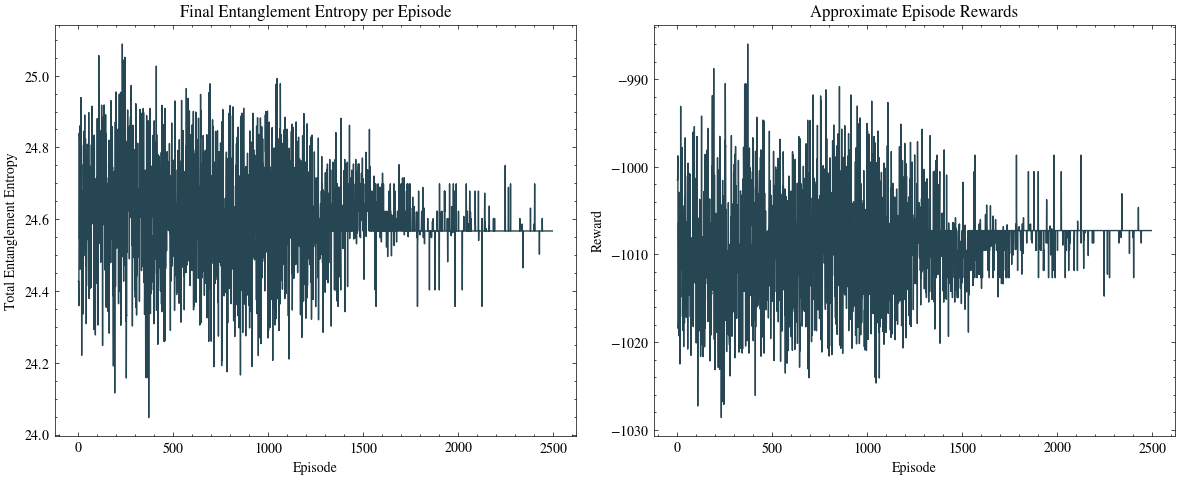

In [9]:
# ─── Training Loop ─────────────────────────────────────────────────────────────
logger.info("Starting training loop...", lvl=1, color='green')

obs, info       = env.reset(seed=config["SEED"])
all_rewards     = []
all_entropies   = []
num_updates     = config["TRAIN"]["TOTAL_TIMESTEPS"] // config["TRAIN"]["NUM_STEPS"]
logger.info(f"Total updates planned: {num_updates}", lvl=2, color='purple')

# Main training loop
for update in range(1, num_updates + 1):
    
    # 1) Rollout Phase - collect transitions and store them
    storage     = []
    for _ in range(config["TRAIN"]["NUM_STEPS"]):
        # Get action, value, and log_prob from the agent
        agent.key, action_key                           = jax.random.split(agent.key)
        action, value, log_prob                         = agent._get_action_and_value(obs, action_key)

        # Step the environment
        next_obs, reward, terminated, truncated, info   = env.step_sparse(int(action))
        done                                            = terminated or truncated
        
        # Store the transition in the storage
        storage.append(Transition(done, action, value, reward, log_prob, obs))
        
        obs                                             = next_obs
        if done:
            logger.info(f"Action: {action}, Reward: {reward:.4f}, Entropy: {info['total_entropy']:.4f}", lvl=4, color='purple')
            all_rewards.append(env.step_count * reward) # Simple proxy for episode return
            all_entropies.append(info['total_entropy'])
            obs, info                                   = env.reset()
    
    # 2) Learning Phase - update the agent with the collected transitions
    # Convert list of transitions to a batched Transition object
    transitions = jax_tree.map(lambda *x: jnp.stack(x), *storage)
    agent.learn(transitions, obs)
    
    if update % 2 == 0:
        logger.info(f"Update {update}/{num_updates} complete.", lvl=3, color='blue')

logger.title("Training Complete", desired_size=80, fill='#', color='green')

# 3. Plotting Results
fig, ax = Plotter.get_subplots(1, 2, figsize=(12, 5))
ax[0].plot(all_entropies)
ax[0].set_title("Final Entanglement Entropy per Episode")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Total Entanglement Entropy")
ax[1].plot(all_rewards)
ax[1].set_title("Approximate Episode Rewards")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
fig.tight_layout()

### Test the entanglement entropies

In [ ]:
#! Test the entanglement loss function with equal coefficients
# coefficients_uniform    = jnp.array([1] + [0] * (gamma - 1))
coefficients_uniform    = jnp.ones(data_mix_jax.shape[1])
coefficients_uniform_n  = jnp.linalg.norm(coefficients_uniform)
coefficients_uniform    = coefficients_uniform / coefficients_uniform_n
logger.info(f"Testing entanglement loss with uniform coefficients... Norm={jnp.linalg.norm(coefficients_uniform):.5f}", lvl=2, color='green')
entanglement_loss_test  = entanglement_loss_calculator_jit(coefficients_uniform)
logger.info(f"Entropy of the demixed state with uniform coefficients: {entanglement_loss_test:.5f}", lvl=3, color='green')
logger.info(f"Original entropy averaged with uniform probabilities: {np.dot(entropy_values['original'], coefficients_uniform**2)}", lvl=3, color='green')

coefficients_random     = jax.random.uniform(key = key, shape=(data_mix_jax.shape[1],))
coefficients_random_n   = jnp.linalg.norm(coefficients_random)
coefficients_random     = coefficients_random / coefficients_random_n
logger.info(f"Testing entanglement loss with random coefficients... Norm={jnp.linalg.norm(coefficients_random):.5f}", lvl=2, color='red')
entanglement_loss_test  = entanglement_loss_calculator_jit(coefficients_random)
logger.info(f"Entropy of the demixed state with random coefficients: {entanglement_loss_test:.5f}", lvl=3, color='red')
logger.info(f"Original entropy averaged with random probabilities: {np.dot(entropy_values['original'], coefficients_random**2)}", lvl=3, color='red')

In [ ]:
# create the distribution of the entanglement entropies
n_samples = 500
gamma     = data_mix_jax.shape[1]           # Number of coefficients (Gamma)
docoeffs  = False
if docoeffs:
    logger.info(f"Using {gamma} coefficients for entanglement entropy distribution calculation.", lvl=2, color='purple')
    entropies = np.zeros(n_samples)         # Array to store entanglement entropies
else:
    entropies = np.zeros(gamma * n_samples) # Array to store entanglement entropies

for i in range(n_samples):
    if docoeffs:
        coefficients    = np.random.normal(size=(gamma,)) + 1j * np.random.normal(size=(gamma,)) # Ensure complex coefficients
        coefficients_n  = np.linalg.norm(coefficients)
        coefficients    = coefficients / (coefficients_n + 1e-11)
        entropies[i]    = entanglement_loss_calculator_jit(coefficients)
    else:
        haar_unitary    = jnp.array(QuadraticSelection.haar_random_unitary(gamma=gamma))
        states          = data_mix_jax @ haar_unitary
        for j in range(gamma):
            schmidt, _                  = schmidt_jax(states[:, j], dim_a, dim_b, use_eig=False) 
            entropies[i * gamma + j]    = vn_entropy_jax(schmidt)
logger.info(f"Entropy distribution: mean={np.mean(entropies):.5f}, std={np.std(entropies):.5f}", lvl=2, color='purple')
logger.info(f"Minimum entropy in distribution: {np.min(entropies):.5f}", lvl=2, color='blue')
logger.info(f"Maximum entropy in distribution: {np.max(entropies):.5f}", lvl=2, color='red')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Entanglement Entropy')
plt.ylabel('Density')
plt.title('Distribution of Entanglement Entropies')
plt.grid()
plt.axvline(x = np.log(2) * ns // 2 - 0.5, color='r',       linestyle='--', label='Page Entropy')
plt.axvline(x = entropy_values['minimum'], color='b',       linestyle='--', label='Minimal Entropy in original States')
plt.axvline(x = entropy_values['maximum'], color='orange',  linestyle='--', label='Maximal Entropy in original States')
plt.axvline(x = entropy_values['average'], color='purple',  linestyle='--', label='Average Entropy in original States')
plt.axvline(x = entropy_values['maximum'],  color='black',  linestyle='--', label='Maximal Entropy + log(gamma)')
plt.legend()